# Airline on time data analysis

**Data source:** [Airline on time data](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/HG7NV7)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import time, date
from scipy.stats import pearsonr



%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

## Importing Data

In [2]:

original_df = pd.concat([pd.read_csv(f'/kaggle/input/data-expo-2009-airline-on-time-data/{file}.csv') for file in ['2006', '2007']])
print(original_df.shape)


(14595137, 29)


In [3]:
airports_df = pd.read_csv('/kaggle/input/data-expo-2009-airline-on-time-data/airports.csv')
print(airports_df.shape)
airports_df.head()

(3376, 7)


,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944


In [4]:
print(original_df.info())

print(original_df.isna().sum()*100/len(original_df))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14595137 entries, 0 to 7453214
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             int64  
 20  TaxiOut            int64  
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       int64  
 25  WeatherDelay     

In [5]:
original_df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2006,1,11,3,743.0,745,1024.0,1018,US,343,N657AW,281.0,273.0,223.0,6.0,-2.0,ATL,PHX,1587,45,13,0,NaN,0,0,0,0,0,0
1,2006,1,11,3,1053.0,1053,1313.0,1318,US,613,N834AW,260.0,265.0,214.0,-5.0,0.0,ATL,PHX,1587,27,19,0,NaN,0,0,0,0,0,0
2,2006,1,11,3,1915.0,1915,2110.0,2133,US,617,N605AW,235.0,258.0,220.0,-23.0,0.0,ATL,PHX,1587,4,11,0,NaN,0,0,0,0,0,0
3,2006,1,11,3,1753.0,1755,1925.0,1933,US,300,N312AW,152.0,158.0,126.0,-8.0,-2.0,AUS,PHX,872,16,10,0,NaN,0,0,0,0,0,0
4,2006,1,11,3,824.0,832,1015.0,1015,US,765,N309AW,171.0,163.0,132.0,0.0,-8.0,AUS,PHX,872,27,12,0,NaN,0,0,0,0,0,0


## Data Processing

In [6]:
print(np.sum([original_df['Diverted'] == 1]))
print(np.sum([original_df['Cancelled'] == 1]))

33365
282682


`AirTime`, `ArrDelay` and `ArrTime` are `NaN` because the flight was cancelled or diverted

`DepTime` and `DepDelay` are `NaN` bacause the flight was cancelled


More than 98% of values in `CancellationCode` are `NaN`, seeing that we don't need to analyse the cancelled flights, so we juest drop the `CancellationCode` columns

In [7]:
original_df.drop(['CancellationCode'], axis=1, inplace=True)

Only very small part of flights were cancelled or diverted, so we can just drop these records and focus on the non-cancelled and non-diverted floghts records

In [8]:
original_df.dropna(axis=0, inplace=True)
len(original_df)
original_df.describe()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,14279090.0,14279090.0,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07
mean,2.006510e+03,6.541218e+00,1.572342e+01,3.943168e+00,1.339755e+03,1.330410e+03,1.484467e+03,1.494512e+03,2.172063e+03,1.261937e+02,1.274648e+02,1.028349e+02,9.451859e+00,1.072296e+01,7.263797e+02,7.024763e+00,1.633590e+01,0.0,0.0,3.716184e+00,7.418885e-01,3.768550e+00,2.789232e-02,4.919834e+00
std,4.999096e-01,3.419741e+00,8.787922e+00,1.993435e+00,4.782309e+02,4.637868e+02,5.040900e+02,4.802920e+02,1.973189e+03,7.124866e+01,7.049628e+01,7.238262e+01,3.800010e+01,3.479113e+01,5.696938e+02,2.229665e+01,1.143029e+01,0.0,0.0,2.008208e+01,9.185072e+00,1.607641e+01,1.196359e+00,2.081230e+01
min,2.006000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00,-2.500000e+01,-1.425000e+03,-5.920000e+02,-1.200000e+03,1.100000e+01,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.006000e+03,4.000000e+00,8.000000e+00,2.000000e+00,9.300000e+02,9.300000e+02,1.108000e+03,1.115000e+03,5.830000e+02,7.500000e+01,7.700000e+01,5.400000e+01,-9.000000e+00,-4.000000e+00,3.180000e+02,4.000000e+00,1.000000e+01,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.007000e+03,7.000000e+00,1.600000e+01,4.000000e+00,1.329000e+03,1.321000e+03,1.515000e+03,1.517000e+03,1.491000e+03,1.080000e+02,1.100000e+02,8.400000e+01,-1.000000e+00,0.000000e+00,5.750000e+02,5.000000e+00,1.400000e+01,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.007000e+03,1.000000e+01,2.300000e+01,6.000000e+00,1.732000e+03,1.720000e+03,1.911000e+03,1.905000e+03,3.431000e+03,1.560000e+02,1.570000e+02,1.310000e+02,1.300000e+01,1.000000e+01,9.540000e+02,8.000000e+00,1.900000e+01,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.007000e+03,1.200000e+01,3.100000e+01,7.000000e+00,2.930000e+03,2.359000e+03,2.955000e+03,2.359000e+03,9.619000e+03,1.879000e+03,6.600000e+02,1.958000e+03,2.598000e+03,2.601000e+03,4.962000e+03,1.501000e+03,6.020000e+02,0.0,0.0,2.580000e+03,1.429000e+03,1.392000e+03,3.820000e+02,1.366000e+03


**Flights data from 2006-2007, non-cancelled, non-diverted flights**


## Q 1. When is the best time of day, day of the week, and time of year to fly to minimise delays?

- There are various factors influencing the minimum delay time, such as airlines, regions, weather, start and end locations, etc. In order to simplify the problem, we will statistics the overall minimum delay time. 
- According to the hours of `CRSDepTime`, group flights into 24 groups, `DepHour` from 0 to 23 : [0, 1), [1, 2) ... [22, 23), [23, 0)

- Delay includes `ArrDelay` and `DepDelay`. the mean of both delays  as the `AvgDelayTime` of the flight.

In [9]:
def conver_flat_time(float_time):
    return int(float_time // 100)
#     minute = int(float_time % 100)
#     return time(hour=hour, minute=minute)

original_df['DepHour'] = original_df['CRSDepTime'].apply(conver_flat_time)
original_df['AvgDelayTime'] = (original_df['ArrDelay'] + original_df['DepDelay'])/2
original_df[['DepHour','CRSDepTime', 'AvgDelayTime']]


Q1_df = original_df[['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime',
                     'CRSArrTime','ArrDelay','DepDelay', 'Origin', 'Dest','DepHour', 'AvgDelayTime']].copy()
Q1_df.dropna(axis=0, inplace=True)
print(len(Q1_df))

14279090


In [10]:
Q1_df.describe()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ArrDelay,DepDelay,DepHour,AvgDelayTime
count,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07,1.427909e+07
mean,2.006510e+03,6.541218e+00,1.572342e+01,3.943168e+00,1.339755e+03,1.330410e+03,1.484467e+03,1.494512e+03,9.451859e+00,1.072296e+01,1.303732e+01,1.008741e+01
std,4.999096e-01,3.419741e+00,8.787922e+00,1.993435e+00,4.782309e+02,4.637868e+02,5.040900e+02,4.802920e+02,3.800010e+01,3.479113e+01,4.626807e+00,3.571569e+01
min,2.006000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-5.920000e+02,-1.200000e+03,0.000000e+00,-5.980000e+02
25%,2.006000e+03,4.000000e+00,8.000000e+00,2.000000e+00,9.300000e+02,9.300000e+02,1.108000e+03,1.115000e+03,-9.000000e+00,-4.000000e+00,9.000000e+00,-6.000000e+00
50%,2.007000e+03,7.000000e+00,1.600000e+01,4.000000e+00,1.329000e+03,1.321000e+03,1.515000e+03,1.517000e+03,-1.000000e+00,0.000000e+00,1.300000e+01,-5.000000e-01
75%,2.007000e+03,1.000000e+01,2.300000e+01,6.000000e+00,1.732000e+03,1.720000e+03,1.911000e+03,1.905000e+03,1.300000e+01,1.000000e+01,1.700000e+01,1.100000e+01
max,2.007000e+03,1.200000e+01,3.100000e+01,7.000000e+00,2.930000e+03,2.359000e+03,2.955000e+03,2.359000e+03,2.598000e+03,2.601000e+03,2.300000e+01,2.599500e+03


### 1. the best time of day

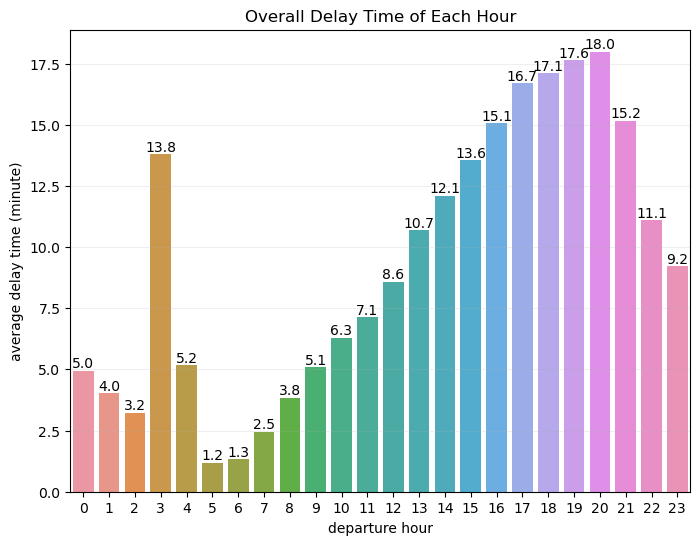

In [11]:
Q1_temp_df = Q1_df.groupby('DepHour', as_index=False).agg({'AvgDelayTime':'mean'})

fig, ax = plt.subplots(figsize=(8,6))
ax = sns.barplot(data=Q1_temp_df, x='DepHour', y='AvgDelayTime',ax=ax)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')
plt.title('Overall Delay Time of Each Hour')
plt.xlabel('departure hour')
plt.ylabel('average delay time (minute)')
plt.grid(True, axis='y', alpha=0.2)
plt.show()


Group flight schedule departure time into 24 hours and plot the average total delay for each grouped time period.  

The average delay time of the flight at `5:00 am` is the smallest, about 1.2 minutes, and then rises all the way until `8:00 pm`. And the average delay time reaches the maximum, around 18 minutes, then the average delay time begins to decrease.


Among them, the delay time at 3:00 a.m. has increased sharply, possibly due to:
1. Fewer staff at the airport and lower efficiency
2. The airport shift change, maintenance at `3.00 pm`
3. Noisy Data Impact

In summary, flight delays are generally lower for morning (`4:00 am` to `10:00 am`) or late night (`0:00 am` to `2:00 am`) flight delays


### 2. the best day of the week

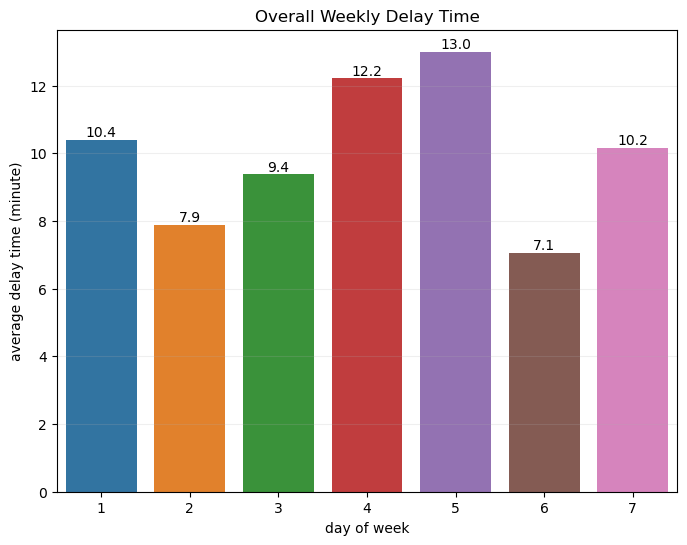

In [12]:
Q1_temp_df = Q1_df.groupby('DayOfWeek', as_index=False).agg({'AvgDelayTime':'mean'})
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(data=Q1_temp_df, x='DayOfWeek', y='AvgDelayTime', ax=ax)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')
plt.title(f'Overall Weekly Delay Time')
plt.xlabel('day of week')
plt.ylabel('average delay time (minute)')
plt.grid(True, axis='y', alpha=0.2)
plt.show()


From the graph we can see that the average flight delay time is lowest on **Saturday**, about 7.1 minutes, following by **Tuesday**, about 7.9 minutes.

### 3. the best time of year

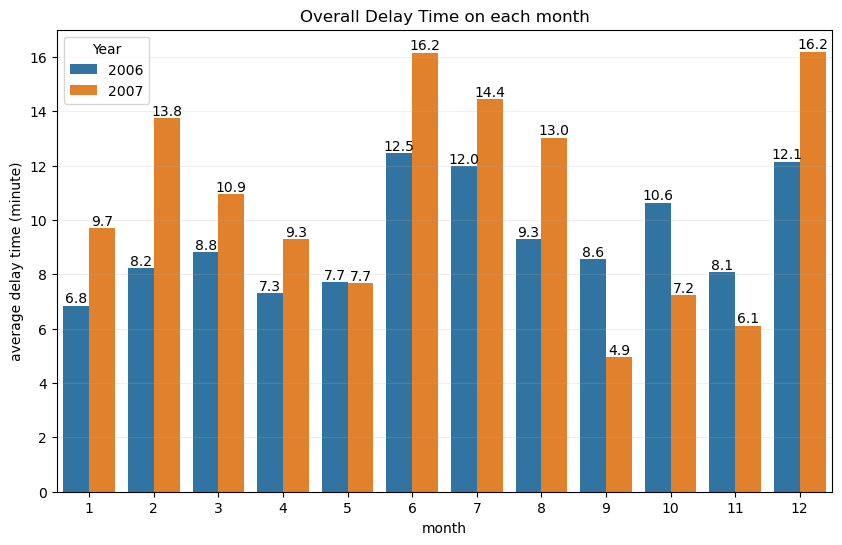

In [13]:
Q1_temp_df = Q1_df.groupby(['Year', 'Month'], as_index=False).agg({'AvgDelayTime':'mean'})
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=Q1_temp_df, x='Month', y='AvgDelayTime', hue='Year')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')
plt.title(f'Overall Delay Time on each month')
plt.xlabel('month')
plt.ylabel('average delay time (minute)')
plt.grid(True, axis='y', alpha=0.2)
plt.show()

**September** is the best month of the year with the lowest average delays, followed by **November**.

## Q2. How does the number of people flying between different locations change over time?

### 1. Dynamic Heatmap: Location distribution of the numbers of flight base on month

In [14]:
Q2_df = pd.merge(Q1_df, airports_df['iata'], left_on='Origin', right_on='iata', how='left')

Q2_temp_df = pd.DataFrame(Q2_df.groupby(['Year', 'Month', 'iata'], as_index=False).size())
Q2_temp_df = Q2_temp_df.rename(columns={'size':'flight_count'})
print(Q2_temp_df.shape)
Q2_temp_df

(6845, 4)


,Year,Month,iata,flight_count
0,2006,1,ABE,386
1,2006,1,ABI,229
2,2006,1,ABQ,2989
3,2006,1,ABY,115
4,2006,1,ACT,211
...,...,...,...,...
6840,2007,12,WRG,55
6841,2007,12,XNA,1117
6842,2007,12,YAK,55
6843,2007,12,YKM,61


In [15]:
flight_df = pd.merge(Q2_temp_df, airports_df[['iata', 'lat', 'long']], on='iata', how='left')
flight_df['flight_count'] /= flight_df['flight_count'].max()/100
heat_data = []
for name, value in flight_df.groupby(['Year', 'Month']):
    heat_data.append(value[['lat', 'long', 'flight_count']].values.tolist())
#     print(name, value[['lat', 'long', 'flight_count']].values.tolist())

flight_df

,Year,Month,iata,flight_count,lat,long
0,2006,1,ABE,1.056203,40.652363,-75.440402
1,2006,1,ABI,0.626608,32.411320,-99.681897
2,2006,1,ABQ,8.178734,35.040222,-106.609194
3,2006,1,ABY,0.314672,31.535515,-84.194473
4,2006,1,ACT,0.577355,31.611288,-97.230519
...,...,...,...,...,...,...
6840,2007,12,WRG,0.150495,56.484326,-132.369824
6841,2007,12,XNA,3.056422,36.281869,-94.306811
6842,2007,12,YAK,0.150495,59.503361,-139.660226
6843,2007,12,YKM,0.166913,46.568170,-120.544059


In [16]:
import folium
from folium import plugins

m = folium.Map([34, -100], zoom_start=4, width='90%', height='90%')

hm = folium.plugins.HeatMapWithTime(heat_data, radius=30, auto_play=True, gradient={0.25:'blue', 0.5:'lime', 0.7:'yellow', 0.9:'orange', 1.0:'red'})
hm.add_to(m)
m.save('./heatmap_with_time.html')
m


The dynamic heat map show the changes of number of flights in different location each month (24 months)

- The distribution of flight airports in the **west coast** and **eastern regions** of the United States is relatively dense, and the flow of flights is relatively large. Especially the flights in **Washington, New York, Los Angeles, and Hawaii** maintain high flow all year round

- The distribution of airports in the west and central regions is relatively sparse, and there are relatively few flights.

### 2. Lineplot: the number of flights changes over time

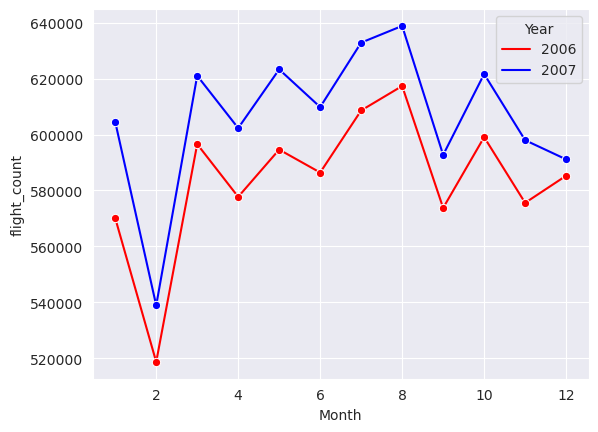

In [17]:
monthly_flight_df = Q2_temp_df.groupby(['Year', 'Month'], as_index=False).agg({'flight_count':'sum'})
sns.set_style("darkgrid")
sns.lineplot(data=monthly_flight_df, x='Month', y='flight_count', hue='Year',marker='o', palette=['red', 'blue'])
plt.show()

The trends in the number of flights over the two years are very similar. Compared with 2006, the number of flights in each month of 2007 has increased, meaning that there are more people fly in 2007, and most of people don't like to fly on **February**, and most people fly in **August**

### 3. Lineplot: Top 10 Aircraft City Routes

In [18]:
# Top 10 Origin and Destination
city_flight_df = Q2_df.groupby(['Year', 'Month','Origin', 'Dest'], as_index=False).size().sort_values(by='size', ascending=False)

city_flight_df = pd.merge(city_flight_df, airports_df[['iata', 'city', 'state']], left_on='Origin', right_on='iata', how='left')
city_flight_df.drop(columns='iata', inplace=True)
city_flight_df.rename(columns={'city':'origin_city', 'state':'origin_state'}, inplace=True)
city_flight_df = pd.merge(city_flight_df, airports_df[['iata', 'city', 'state']], left_on='Dest', right_on='iata', how='left')
city_flight_df.drop(columns='iata', inplace=True)
city_flight_df.rename(columns={'city':'dest_city', 'state':'dest_state'}, inplace=True)

city_flight_df['origin_dest_city'] = city_flight_df['origin_city'] + '-' + city_flight_df['dest_city']
city_flight_df['Year_Month'] =  city_flight_df[['Year','Month']].apply(lambda x: date(x['Year'], x['Month'], 1), axis=1)
city_flight_df.head(10)

,Year,Month,Origin,Dest,size,origin_city,origin_state,dest_city,dest_state,origin_dest_city,Year_Month
0,2006,7,HNL,OGG,1663,Honolulu,HI,Kahului,HI,Honolulu-Kahului,2006-07-01
1,2006,7,OGG,HNL,1661,Kahului,HI,Honolulu,HI,Kahului-Honolulu,2006-07-01
2,2006,8,HNL,OGG,1586,Honolulu,HI,Kahului,HI,Honolulu-Kahului,2006-08-01
3,2006,8,OGG,HNL,1585,Kahului,HI,Honolulu,HI,Kahului-Honolulu,2006-08-01
4,2007,8,OGG,HNL,1398,Kahului,HI,Honolulu,HI,Kahului-Honolulu,2007-08-01
5,2007,8,HNL,OGG,1398,Honolulu,HI,Kahului,HI,Honolulu-Kahului,2007-08-01
6,2007,1,OGG,HNL,1395,Kahului,HI,Honolulu,HI,Kahului-Honolulu,2007-01-01
7,2006,12,OGG,HNL,1388,Kahului,HI,Honolulu,HI,Kahului-Honolulu,2006-12-01
8,2006,12,HNL,OGG,1381,Honolulu,HI,Kahului,HI,Honolulu-Kahului,2006-12-01
9,2007,3,OGG,HNL,1375,Kahului,HI,Honolulu,HI,Kahului-Honolulu,2007-03-01


{'Kahului-Honolulu', 'Los Angeles-Las Vegas', 'New York-Chicago', 'Honolulu-Kahului', 'New York-Boston', 'New York-Arlington', 'Houston-Dallas', 'Arlington-New York', 'Chicago-New York', 'Boston-New York'}


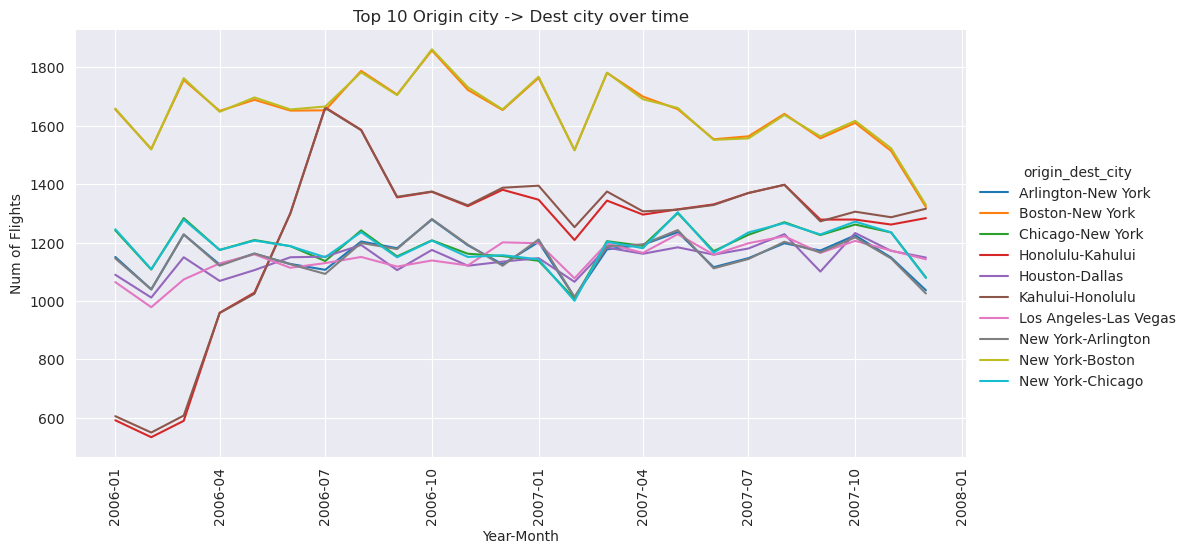

In [19]:
# Top 5 Origin city -> Dest city over time
top = 10
top_travel_df = city_flight_df.groupby(['origin_city', 'dest_city'], as_index=False).agg({'size':'sum'}).sort_values(by='size', ascending=False)
top10_travel_city = set(top_travel_df['origin_city'][:top] + '-' + top_travel_df['dest_city'][:top])
print(top10_travel_city)

top10_city_flight_df = city_flight_df[city_flight_df['origin_dest_city'].isin(top10_travel_city)]
top10_city_flight_df = top10_city_flight_df.groupby(['Year_Month', 'origin_dest_city'], as_index=False).agg({'size':'sum'})

ax = sns.relplot(data=top10_city_flight_df, x='Year_Month', y='size',  hue='origin_dest_city', kind='line', height=5, aspect=2, errorbar=None)
plt.title('Top 10 Origin city -> Dest city over time')
plt.xlabel('Year-Month')
plt.ylabel('Num of Flights')
plt.xticks(rotation=90)
plt.show()

A city may have multiple airports, here I have find the top 10 city routes with the highest number of flights, and show their change by line chart. As shown in the line chart:

- **Top 10 flight routes among cities**:

1. **Round-trip routes between New York and Arlington, Boston, Chicago**
2. **Round-trip routes between Honolulu and Kahului, Dallas**
3. **From Los Angeles to Las Vegas**

- The number of round-trip flights between the two cities is similar
- A large number of people commute between **New York and Boston** all year round
- The number of people traveling by plane between **Honolulu and Kahului** increased rapidly from February 2006 to July

## Q3. Can you detect cascading failures as delays in one airport create delays in others?

### 1. DepDelay and ArrDelay

To detect the effect of one arriving delayed flight on another delayed flight, we need to prove that **delayed arrival of previous flight causing subsequent flight to take off late, and delayed takeoff will result in delayed arrival, resulting in cascading delays**. 

i.e. we need to show that **departure delays are strongly correlated with arrival delays**.

Calculate the **Pearson correlation coefficient** of departure delay and arrival delay to prove the correlation between the both

**Null hyphothesis**: Departure delay and arrival delay are independent of each other

Set the significance level at **0.05**

In [46]:
significance_level = 0.005
null_hyphothesis = 'DepDelay and ArrDelay are independent of each other'

print(f'Set the significance level at {significance_level}, null hyphothesis: {null_hyphothesis}')

corr_coef, p_value = pearsonr(Q3_df['ArrDelay'], Q3_df['DepDelay'])
print('p value: %0.4f'%(p_value))
print('pearson correlation coefficient: ', corr_coef)

if p_value > significance_level:
    print('Accept null hyphothesis')
else:
    print('Reject null hyphothesis')

Set the significance level at 0.005, null hyphothesis: DepDelay and ArrDelay are independent of each other
p value: 0.0000
pearson correlation coefficient:  0.9398918499768079
Reject null hyphothesis


It means departure delays are strongly correlated with arrival delays, so one delay flight which causes other take off late can create delays in others.

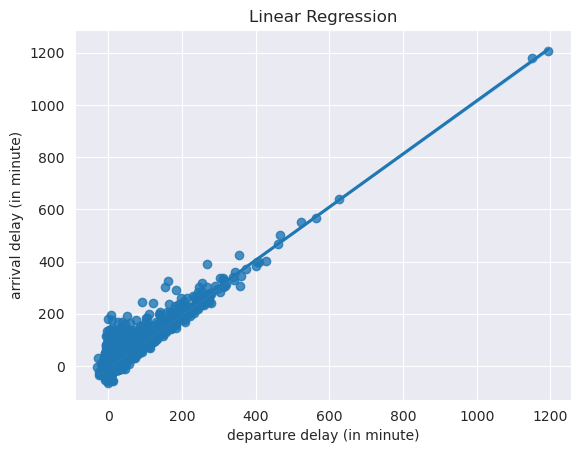

,DepDelay,ArrDelay
count,20000.000000,20000.000000
mean,10.773550,9.340600
std,35.821117,39.012903
min,-30.000000,-65.000000
25%,-4.000000,-9.000000
50%,0.000000,-1.000000
75%,10.000000,13.000000
max,1194.000000,1205.000000


In [22]:
sample = Q1_df[['DepDelay', 'ArrDelay']].iloc[np.random.randint(0, len(Q1_df), 20000)]

sns.regplot(data=sample, x='DepDelay', y='ArrDelay')
plt.title('Linear Regression')
plt.xlabel('departure delay (in minute)')
plt.ylabel('arrival delay (in minute)')

plt.show()
sample.describe()



Randomly take 20000 samples, run the linear regression model, we can see that **departure delay and arrival delay are linearly related**


### 2. LateAircraftDelay and DepDelay, ArrDelay

`LateAircraftDelay` is a result of the late arrival of the previous flight that utilized the same plane that will be departing,which causes the current flight to take off late

So, we will talk about the correlation between `LateAircraftDelay` and `DepDelay`, `ArrDelay`, to prove that previous delay can create delays in others

In [40]:
Q3_df = original_df[original_df['LateAircraftDelay'] != 0][['DepDelay','ArrDelay','LateAircraftDelay']]

In [41]:
significance_level = 0.005
null_hyphothesis = 'LateAircraftDelay and ArrDelay are independent of each other'

print(f'Set the significance level at {significance_level}, null hyphothesis: {null_hyphothesis}')

corr_coef, p_value = pearsonr(Q3_df['ArrDelay'], Q3_df['LateAircraftDelay'])
print('p value: %0.4f'%(p_value))
print('pearson correlation coefficient: ', corr_coef)

if p_value > significance_level:
    print('Accept null hyphothesis')
else:
    print('Reject null hyphothesis')

Set the significance level at 0.005, null hyphothesis: LateAircraftDelay and ArrDelay are independent of each other
p value: 0.0000
pearson correlation coefficient:  0.8013050090098293
Reject null hyphothesis


In [42]:
significance_level = 0.005
null_hyphothesis = 'LateAircraftDelay and DepDelay are independent of each other'

print(f'Set the significance level at {significance_level}, null hyphothesis: {null_hyphothesis}')

corr_coef, p_value = pearsonr(Q3_df['DepDelay'], Q3_df['LateAircraftDelay'])
print('p value: %0.4f'%(p_value))
print('pearson correlation coefficient: ', corr_coef)

if p_value > significance_level:
    print('Accept null hyphothesis')
else:
    print('Reject null hyphothesis')

Set the significance level at 0.005, null hyphothesis: LateAircraftDelay and DepDelay are independent of each other
p value: 0.0000
pearson correlation coefficient:  0.8257318879775004
Reject null hyphothesis


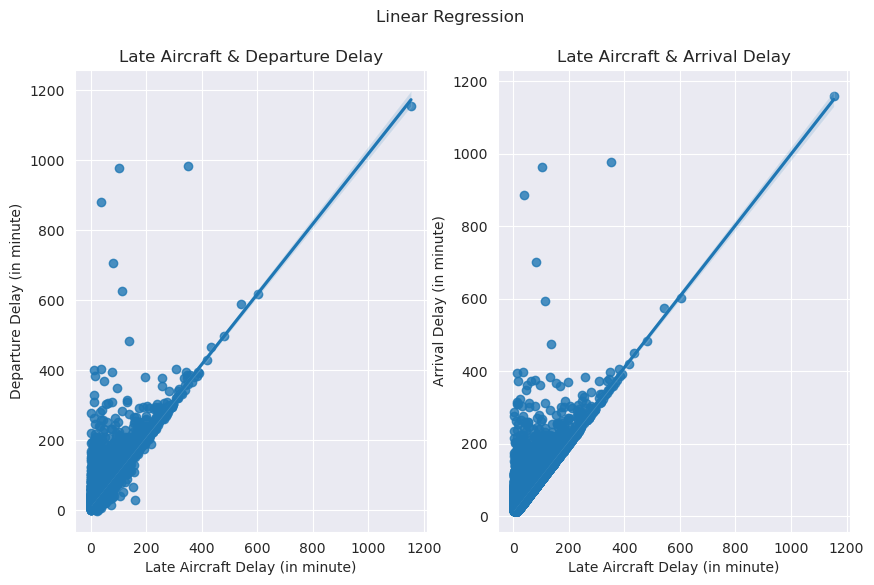

In [44]:
sample = Q3_df.iloc[np.random.randint(0, len(Q3_df), 10000)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
plt.suptitle('Linear Regression')

sns.regplot(data=sample, x='LateAircraftDelay', y='DepDelay', ax=ax1)
ax1.set_title('Late Aircraft & Departure Delay')
ax1.set_xlabel('Late Aircraft Delay (in minute)')
ax1.set_ylabel('Departure Delay (in minute)')


sns.regplot(data=sample, x='LateAircraftDelay', y='ArrDelay', ax=ax2)
ax2.set_title('Late Aircraft & Arrival Delay')
ax2.set_xlabel('Late Aircraft Delay (in minute)')
ax2.set_ylabel('Arrival Delay (in minute)')
plt.show()



Using same method, through **Pearson correlation coefficient** and **Linear regression**, as the result showing, the pearson corrlation coefficient between `LateAircaftDelay` and `DepDelay`, `ArrDelay` are `0.82` and `0.80` respectively, and results of linear regression show they are linear correlation. **In sum up, previous flight delay can create delays in other, which causes cascading delays.**

## Q4. Use the available variables to construct a model	that	predicts	delays.

In [35]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

import collections

I use the sklearn library to build a model to predict `ArrDelay`

- **Feature selection**

1. Preliminary Selection Features: drop the variables which can calculate the `ArrDelay` directly, like `DepDelay`, `AirrTime`, `ActualElapsedTime`  etc. and drop other low relative columns, like `FlightNum`, `TailNum` etc.

2. Calculate the `Pearson correlation coefficient` between `ArrDelay` and the rest of features, then select the features which the correlation coefficient is over `0.1`

In [36]:
# feature selection
"""
['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime',
                     'CRSArrTime','ArrDelay','DepDelay', 'Origin', 'Dest','DepHour', 'AvgDelayTime','FlightNum', 'TailNum']
"""
features = ['Year', 'Month', 'DayofMonth', 'DayOfWeek',  'CRSDepTime', 'CRSArrTime', 'CRSElapsedTime', 
            'Distance', 'LateAircraftDelay','WeatherDelay','NASDelay','SecurityDelay', 'DepHour']
feature_corr_dict = {}
for col in features:
    if original_df[col].dtype != object:
        corr_coef, p_value = pearsonr(original_df['ArrDelay'], original_df[col])
        feature_corr_dict[col] = corr_coef
feature_corr_dict

{'Year': 0.019856097275487473,
 'Month': 0.009250934508127863,
 'DayofMonth': 0.01882833734888878,
 'DayOfWeek': -0.0001015698864898728,
 'CRSDepTime': 0.13702926211665709,
 'CRSArrTime': 0.13286618660111243,
 'CRSElapsedTime': 0.0008814661327396312,
 'Distance': -0.006344158121619856,
 'LateAircraftDelay': 0.6127111148405723,
 'WeatherDelay': 0.2789710059920443,
 'NASDelay': 0.4968852652834359,
 'SecurityDelay': 0.034280813867398376,
 'DepHour': 0.13671970808959905}

In [37]:
features = []
for k, val in feature_corr_dict.items():
    if val > 0.1:
        features.append(k)
features

['CRSDepTime',
 'CRSArrTime',
 'LateAircraftDelay',
 'WeatherDelay',
 'NASDelay',
 'DepHour']

**Generate quadratic polynomials by `PolynomialFeatures`**

There are too few data features. In order to improve the accuracy of prediction, polynomial features are used

In [38]:
X_data, y_data = original_df[features], original_df['ArrDelay']

# scaler = MinMaxScaler()
# X_data = pd.DataFrame(scaler.fit_transform(X_data), columns=X_data.columns)

poly = PolynomialFeatures(degree=2,include_bias=False, interaction_only=True)
X_data = poly.fit_transform(X_data)

- **Data Split**

 Split data into training set and testing set, testing set ratio is `0.3`

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3)
print(X_train.shape, X_test.shape)

(9995363, 21) (4283727, 21)


- **Model Training and Evaluation**

  - Use `StanderdScaler` to standardize the data set, and make mean of each column of data is 0 and the standard deviation is 1

  - Build`Polynomial regression` models with the `L1` norm, and use `GridSearch` to find the best parameters

  - As a regression prediction problem, `R-Squared` and mean squared error (`MSE`) will be used for evaluating the model

In [31]:
models = {
    'LR': Pipeline([('scaler', StandardScaler(with_mean=False)), ('LR', LinearRegression())]),
    'EN': Pipeline([('scaler', StandardScaler(with_mean=False)), ('LA', Lasso())])}

params = {'EN':{'LA__alpha':[0.05, 0.1]}}

record = collections.defaultdict(list)

for name, model in models.items():

    if name in params.keys():
        model = GridSearchCV(model, params[name], cv=None)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    r_squared_train = r2_score(y_train, y_train_pred)
    r_squared_test = r2_score(y_test, y_test_pred)
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    record['train_r2'] = r_squared_train
    record['test_r2'] = r_squared_test
    record['train_mse'] = mse_train
    record['test_mse'] = mse_test

    print('Train:')
    print('R-squared:', r_squared_train)
    print('MSE:', mse_train)
    print('Test:')
    print('R-squared:', r_squared_test)
    print('MSE:', mse_test)
    
    if name in params.keys():
        print(model.best_params_)

Train:
R-squared: 0.6495267447874398
MSE: 506.57561385776535
Test:
R-squared: 0.6492245418404204
MSE: 505.37932887907516
Train:
R-squared: 0.6492914266850875
MSE: 506.91574369756916
Test:
R-squared: 0.6489749226559223
MSE: 505.73896742562266
{'LA__alpha': 0.05}


- **Polynomial regression:**

    Train:
    R-squared: 0.6495267447874398
    MSE: 506.57561385776535

    Test:
    R-squared: 0.6492245418404204
    MSE: 505.37932887907516
    

- **Polynomial regression with L1:**

    Train:
    R-squared: 0.6492914266850875
    MSE: 506.91574369756916

    Test:
    R-squared: 0.6489749226559223
    MSE: 505.73896742562266

    {'LA__alpha': 0.05}